In [1]:
import shap
import torch
import numpy as np
from pathlib import Path
from agent import DQN
import random
import matplotlib.pyplot as plt
import tqdm
from environment import DuplicatedCoordsEnv
import pandas as pd

## Setting DQN Model

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
save_path = Path("save")
save_path.exists()

True

In [4]:
data_dir_lr = save_path / "7-21-LR"
data_dir_ew = save_path / "7-8-EW"
print(data_dir_lr.exists())
print(data_dir_ew.exists())

True
True


In [5]:
data_path_lr = data_dir_lr / "data.tar" 
print(data_path_lr.exists())
data_path_ew = data_dir_ew / "data.tar"
print(data_path_ew.exists())

True
True


In [6]:
data_dict_lr = torch.load(data_path_lr, weights_only=False, map_location=DEVICE)
data_dict_lr.keys()
data_dict_ew = torch.load(data_path_ew, weights_only=False, map_location=DEVICE)
data_dict_ew.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'all_qvalues', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

In [7]:
# ASSUMING EQUAL ARCHITECTURES
parameters = data_dict_lr['p']
n_observations = parameters.n_observations
n_actions = parameters.n_actions
n_units = parameters.n_hidden_units

In [8]:
model = DQN(n_observations, n_actions, n_units)

In [9]:
env = data_dict_lr['env']

Since the SHAP explainers work with NumPy arrays, not Tensors, we need a wrapper to convert the DQN input/output tensors to NumPy arrays for the explainers.

In [10]:
class WrappedModel:
    def __init__(self, model, device='cuda'):
        self.model = model.eval().to(device)  # eval mode and move to GPU
        self.device = device

    def __call__(self, inputs_numpy):
        # Convert NumPy → PyTorch tensor and move to GPU
        inputs_tensor = torch.tensor(inputs_numpy, dtype=torch.float32).to(self.device)

        # Forward pass (no gradients needed)
        with torch.no_grad():
            outputs_tensor = self.model(inputs_tensor)

        # Move output back to CPU and convert to NumPy
        return outputs_tensor.cpu().numpy()
    
    # Option 1: return full Q-vector
    def q_vector_fn(x_numpy):
        x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
        with torch.no_grad():
            q_vals = self.model(x_tensor)
        return q_vals.numpy()

    # Option 2: return Q-value for chosen action (say action 2)
    def chosen_action_fn(x_numpy, action_idx=2):
        x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
        with torch.no_grad():
            q_vals = self.model(x_tensor)
        return q_vals[:, action_idx].unsqueeze(1).numpy()  # shape (batch, 1)


In [30]:
# Loading Specific Agent Model
model_path = data_dir / f'trained-agent-state-0.pt'
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=21, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [16]:
wrapped_model = WrappedModel(model, device='cpu')

NameError: name 'WrappedModel' is not defined

Now we need to reconstruct the replay buffer of the trained agent in order to sample states to use for the SHAP explainer. We want to get representative states.

In [12]:
all_states = data_dict['all_states']
print(all_states.shape)
agent_index = 0
print(all_states[agent_index].shape)
agent_eps = all_states[agent_index]

(100, 200)
(200,)


By manual inspection of the training log for the agent, you can see when the replay buffer ends (look for when loss stops being nan).

In [13]:
replay_buffer_idx = 82 # TODO: somehow manually automate this, 83 EW 82 LR

replay_buffer_ep = agent_eps[:replay_buffer_idx]
replay_buffer_states = [state for episode in replay_buffer_ep for state in episode]
assert len(replay_buffer_states) > 5000

The background data is a representative sample of states we will feed to the SHAP explainer. The explainer will use these states for masking and determining feature importance.

In [26]:
background_data = random.sample(replay_buffer_states, k=1000) # CONSIDER THE SAMPLING METHOD / SIZE

# Assume background_data is a list of 1D state tensors
background_tensor = torch.stack(background_data)           # shape: (N, num_features)
background_numpy = background_tensor.cpu().numpy()         # convert to NumPy

## Engineering Features

In [ ]:


state_fixed = {'cue': torch.tensor(0), 'x': -2, 'y': 0, 'direction': 270}
state_fixed_tensor = DuplicatedCoordsEnv.conv_dict_to_flat_duplicated_coords(self=env, state=state_fixed)
print(state_fixed_tensor)

tensor([ 1.0000e+00,  0.0000e+00,  0.0000e+00,  4.0000e+00,  2.0000e+00,
         1.0000e+00, -1.1925e-08,  0.0000e+00,  2.0000e+00, -1.0000e+00,
         1.1925e-08,  4.4721e+00,  8.9443e-01,  4.4721e-01,  8.9443e-01,
        -4.4721e-01,  2.0000e+00, -4.3711e-08,  1.0000e+00,  1.9471e-07,
         1.0000e+00])


## GradientExplainer

In [279]:
explainer = shap.GradientExplainer(model, background_tensor) # for GradientExplainer needs raw DQN model and raw Tensor data

In [281]:
non_replay_buffer_ep = agent_eps[replay_buffer_idx:]
non_replay_buffer_states = [state for episode in non_replay_buffer_ep for state in episode]

random_state = torch.stack(random.sample(non_replay_buffer_states, k=1)) # you could explain batches of states ; increase k value
print(random_state)

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  4.0000e+00,  2.0000e+00,
          1.0000e+00, -4.8876e-07,  0.0000e+00,  2.0000e+00, -1.0000e+00,
          4.8876e-07,  4.4721e+00,  8.9443e-01,  4.4721e-01,  8.9443e-01,
         -4.4721e-01,  2.0000e+00, -4.3711e-08,  1.0000e+00,  4.3313e-07,
          1.0000e+00]])


In [282]:
shap_values = explainer.shap_values(random_state)[0] # NOT DETERMINISTIC
print(random_state)
print(shap_values)

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  4.0000e+00,  2.0000e+00,
          1.0000e+00, -4.8876e-07,  0.0000e+00,  2.0000e+00, -1.0000e+00,
          4.8876e-07,  4.4721e+00,  8.9443e-01,  4.4721e-01,  8.9443e-01,
         -4.4721e-01,  2.0000e+00, -4.3711e-08,  1.0000e+00,  4.3313e-07,
          1.0000e+00]])
[[-1.73413831e-02 -1.59384753e-02 -2.39813062e-02]
 [-1.34144840e-02 -8.12280425e-03 -1.14885932e-02]
 [ 1.94150724e-03  1.42284166e-02 -2.87103641e-02]
 [ 1.11884742e-01  1.11030598e-01  9.19132668e-02]
 [ 1.18308267e-02  1.18795197e-02  8.19726869e-02]
 [ 9.34868662e-03  8.55949989e-03 -3.44714911e-03]
 [-4.32918415e-03 -4.78477142e-03 -5.60385000e-03]
 [-1.57442378e-01 -1.40955653e-01 -2.03066632e-01]
 [-8.85608217e-03 -2.29512770e-03  2.96288117e-02]
 [-8.98487263e-04  4.96319348e-06 -1.38643624e-02]
 [-5.55040093e-03 -8.09225753e-03 -6.31648698e-03]
 [ 3.74411517e-02  4.41621692e-02  7.50320626e-02]
 [ 1.02699694e-02  9.70630575e-03  9.74301018e-03]
 [-2.69335223e-03

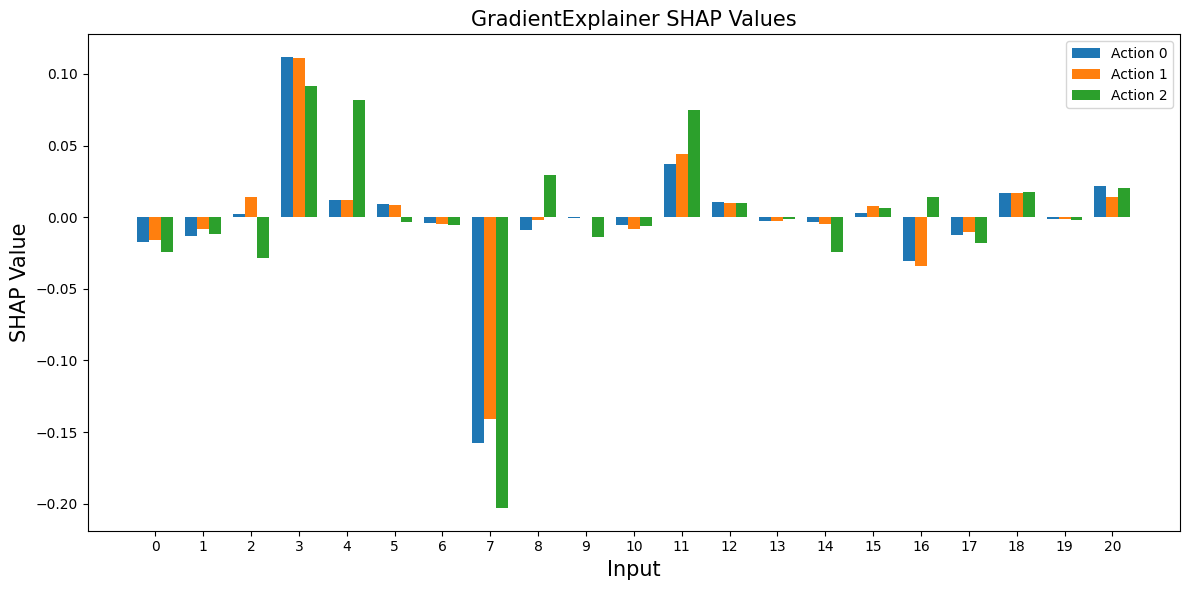

In [284]:
data = np.array(shap_values)
num_groups = len(data)
num_bars = data.shape[1]

x = np.arange(num_groups)  # positions for groups
bar_width = 0.25

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each of the 3 bars per group
for i in range(num_bars):
    ax.bar(x + i * bar_width, data[:, i], width=bar_width, label=f'Action {i}')

# Styling
ax.set_xlabel('Input', fontsize=15)
ax.set_ylabel('SHAP Value', fontsize=15)
ax.set_title('GradientExplainer SHAP Values', fontsize=15)
ax.set_xticks(x + bar_width)
ax.set_xticklabels([str(i) for i in range(num_groups)])
ax.legend()

plt.tight_layout()
plt.savefig('figures/shapvaluesge3.png',dpi=300)
plt.show()

## KernelExplainer

In [285]:
explainer = shap.KernelExplainer(wrapped_model, background_numpy)

In [129]:
random_state = torch.stack(random.sample(non_replay_buffer_states, k=1)).numpy()
print(random_state)

[[ 0.          1.          0.          1.          2.         -0.
  -1.          3.          2.          0.          1.          2.236068
   0.44721356  0.89442724 -0.89442724 -0.4472135   3.6055512   0.8320503
   0.5547002   0.5547002   0.8320503 ]]


In [286]:
random_state = random_state.numpy()

In [287]:
print(random_state)

[[ 0.0000000e+00  0.0000000e+00  1.0000000e+00  4.0000000e+00
   2.0000000e+00  1.0000000e+00 -4.8876205e-07  0.0000000e+00
   2.0000000e+00 -1.0000000e+00  4.8876205e-07  4.4721360e+00
   8.9442718e-01  4.4721359e-01  8.9442700e-01 -4.4721401e-01
   2.0000000e+00 -4.3711388e-08  1.0000000e+00  4.3312576e-07
   1.0000000e+00]]


In [288]:
shap_values = explainer.shap_values(random_state)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

In [289]:
print(shap_values)

[[-0.03121467 -0.02426503 -0.02098814]
 [-0.01554697  0.         -0.01692513]
 [-0.01539399  0.         -0.02668888]
 [ 0.09902786  0.09672739  0.08302258]
 [ 0.03625996  0.01673112  0.07007444]
 [ 0.          0.00935275  0.        ]
 [ 0.          0.          0.        ]
 [-0.1517007  -0.12964322 -0.15281754]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.03711109  0.03919872  0.05565786]
 [ 0.          0.00756707  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         -0.01599134]
 [ 0.          0.          0.        ]
 [ 0.         -0.02701167  0.        ]
 [-0.01610744  0.         -0.01810256]
 [ 0.01641861  0.0131771   0.01833296]
 [ 0.          0.          0.        ]
 [ 0.01986895  0.01086867  0.        ]]


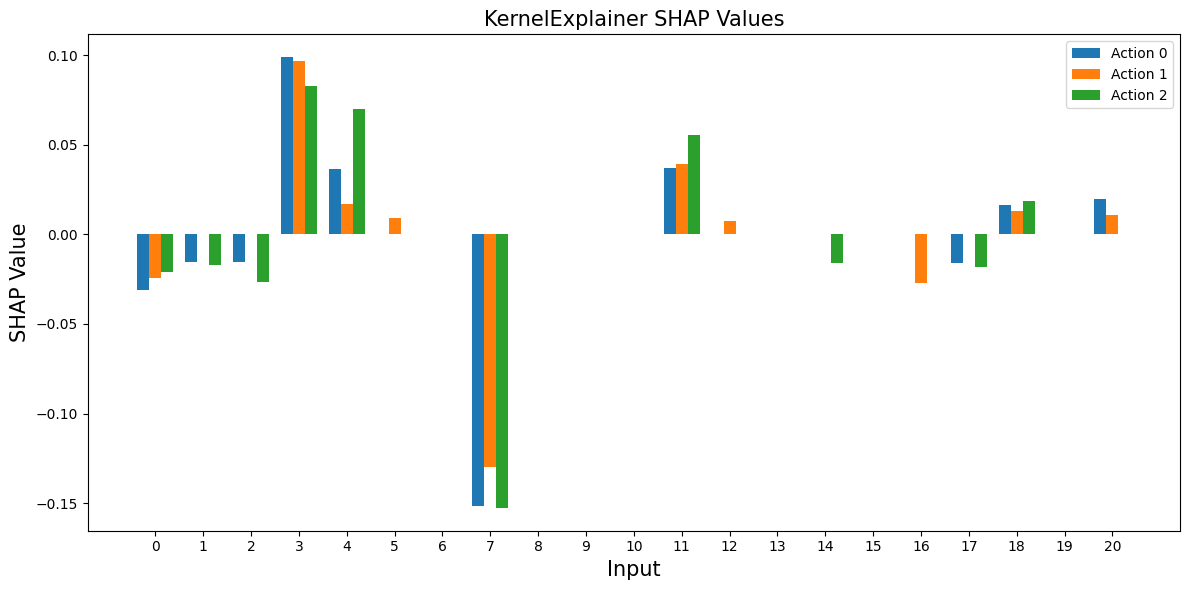

In [290]:
data = np.array(shap_values)
num_groups = len(data)
num_bars = data.shape[1]

x = np.arange(num_groups)  # positions for groups
bar_width = 0.25

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each of the 3 bars per group
for i in range(num_bars):
    ax.bar(x + i * bar_width, data[:, i], width=bar_width, label=f'Action {i}')

# Styling
ax.set_xlabel('Input', fontsize=15)
ax.set_ylabel('SHAP Value', fontsize=15)
ax.set_title('KernelExplainer SHAP Values', fontsize=15)
ax.set_xticks(x + bar_width)
ax.set_xticklabels([str(i) for i in range(num_groups)])
ax.legend()

plt.tight_layout()
plt.savefig('figures/shapvalueske3.png', dpi=300)
plt.show()

## DeepExplainer

In [28]:
print(background_tensor.shape)

torch.Size([1000, 21])


In [ ]:
device = next(model.parameters()).device 
print(device)

cpu


In [ ]:
background_tensor = background_tensor.to(device)  # if you're using `.to()` on model, ensure background_data and model are on same device

In [33]:
background_tensor = background_tensor.float()

In [37]:
# Set print options to show all elements (no summarization)
torch.set_printoptions(profile="full")

print(background_tensor)

# Reset back to default (optional)
torch.set_printoptions(profile="default")

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  3.0000e+00,
          8.7423e-08,  1.0000e+00,  3.0000e+00,  1.0000e+00, -8.7423e-08,
         -1.0000e+00,  3.1623e+00,  3.1623e-01,  9.4868e-01,  9.4868e-01,
          3.1623e-01,  3.1623e+00,  9.4868e-01,  3.1623e-01, -3.1623e-01,
         -9.4868e-01],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  4.0000e+00,
          8.7423e-08,  1.0000e+00,  4.0000e+00,  0.0000e+00, -8.7423e-08,
         -1.0000e+00,  4.0000e+00, -4.3711e-08,  1.0000e+00,  1.0000e+00,
         -1.1921e-07,  4.0000e+00,  1.0000e+00,  0.0000e+00, -1.6292e-07,
         -1.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00,  4.0000e+00,  0.0000e+00,
          1.0000e+00, -4.8876e-07,  0.0000e+00,  4.0000e+00, -1.0000e+00,
          4.8876e-07,  4.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         -4.8876e-07,  4.0000e+00, -4.3711e-08,  1.0000e+00,  4.3313e-07,
          1.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e

In [38]:
explainer = shap.DeepExplainer(model, background_tensor)

In [39]:
non_replay_buffer_ep = agent_eps[replay_buffer_idx:]
non_replay_buffer_states = [state for episode in non_replay_buffer_ep for state in episode]

random_state = torch.stack(random.sample(non_replay_buffer_states, k=1)) # you could explain batches of states ; increase k value
print(random_state)

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  4.0000e+00,  2.0000e+00,
          1.0000e+00, -4.8876e-07,  0.0000e+00,  2.0000e+00, -1.0000e+00,
          4.8876e-07,  4.4721e+00,  8.9443e-01,  4.4721e-01,  8.9443e-01,
         -4.4721e-01,  2.0000e+00, -4.3711e-08,  1.0000e+00,  4.3313e-07,
          1.0000e+00]])


In [ ]:
shap_values = explainer.shap_values(random_state)[0] # deterministic?
print(shap_values)

[[-0.03851409 -0.02717447 -0.03610266]
 [ 0.00147271 -0.00568126  0.00709053]
 [ 0.03816135  0.01008777  0.0370416 ]
 [ 0.13158269  0.12605053  0.10933832]
 [ 0.01255046  0.01267116  0.00929045]
 [ 0.00785938  0.00350418  0.00774318]
 [-0.00595381 -0.00602099 -0.00626908]
 [-0.1273078  -0.11184373 -0.11860337]
 [ 0.00301676  0.0073718  -0.00305705]
 [-0.001705   -0.00455489 -0.00168037]
 [-0.00430564 -0.0036481  -0.0047093 ]
 [ 0.05169147  0.05331637  0.05339474]
 [ 0.0096694   0.00817916  0.00883417]
 [-0.00482513 -0.00402288 -0.00393193]
 [-0.01666285 -0.01668244 -0.01434076]
 [-0.00262988 -0.00356791 -0.00172121]
 [-0.04597293 -0.01991399 -0.04456484]
 [-0.01215395 -0.01245443 -0.0089232 ]
 [ 0.0188385   0.01859452  0.01602013]
 [-0.00420809 -0.0050872  -0.00390331]
 [ 0.01981588  0.01316512  0.02099977]]


In [61]:
[v[0] for v in shap_values]

[np.float64(-0.03851408511400223),
 np.float64(0.0014727084198966622),
 np.float64(0.038161348551511765),
 np.float64(0.13158269226551056),
 np.float64(0.012550456449389458),
 np.float64(0.007859375327825546),
 np.float64(-0.005953814368695021),
 np.float64(-0.12730780243873596),
 np.float64(0.00301675614900887),
 np.float64(-0.0017049970338121057),
 np.float64(-0.0043056439608335495),
 np.float64(0.05169146880507469),
 np.float64(0.009669400751590729),
 np.float64(-0.004825127311050892),
 np.float64(-0.016662849113345146),
 np.float64(-0.0026298791635781527),
 np.float64(-0.04597293213009834),
 np.float64(-0.012153951451182365),
 np.float64(0.01883849874138832),
 np.float64(-0.004208086524158716),
 np.float64(0.019815877079963684)]

In [ ]:
from environment import DuplicatedCoordsEnv

state_fixed = {'cue': torch.tensor(0), 'x': -2, 'y': 0, 'direction': 270}
state_fixed_tensor = DuplicatedCoordsEnv.conv_dict_to_flat_duplicated_coords(self=env, state=state_fixed).unsqueeze(0)
print(state_fixed_tensor)

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  4.0000e+00,  2.0000e+00,
          1.0000e+00, -1.1925e-08,  0.0000e+00,  2.0000e+00, -1.0000e+00,
          1.1925e-08,  4.4721e+00,  8.9443e-01,  4.4721e-01,  8.9443e-01,
         -4.4721e-01,  2.0000e+00, -4.3711e-08,  1.0000e+00,  1.9471e-07,
          1.0000e+00]])


## Comparing Explainers and Iterating Over Agents

In [11]:
input_labels = ['No Odor', 'Odor A', 'Odor B', 'CNP x', 'CNP y', 'CNP cos head', 'CNP sin head', 'CSP x', 'CSP y', 'CSP cos head', 'CSP sin head',
                'PNP length', 'PNP cos alpha', 'PNP sin alpha', 'PNP cos head', 'PNP sin head', 'PSP length', 'PSP cos alpha', 'PSP sin alpha',
                'PSP cos head', 'PSP sin head']
print(len(input_labels))

21


### SHAP Values, Different Methods, Varying States, Actions Separated

  0%|          | 0/3 [00:00<?, ?it/s]Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_87662/2910532766.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 33%|███▎      | 1/3 [00:55<01:50, 55.26s/it]Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_87662/2910532766.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 67%|██████▋   | 2/3 [01:45<00:52, 52.42s/it]Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_87662/2910532766.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
100%|██████████| 3/3 [02:36<00:00, 52.27s/it]


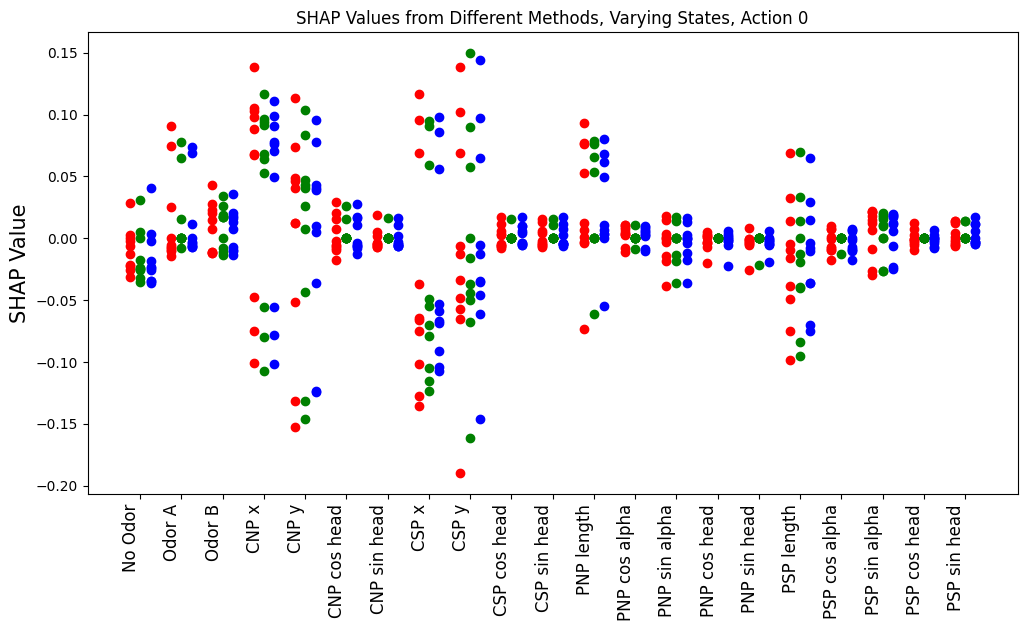

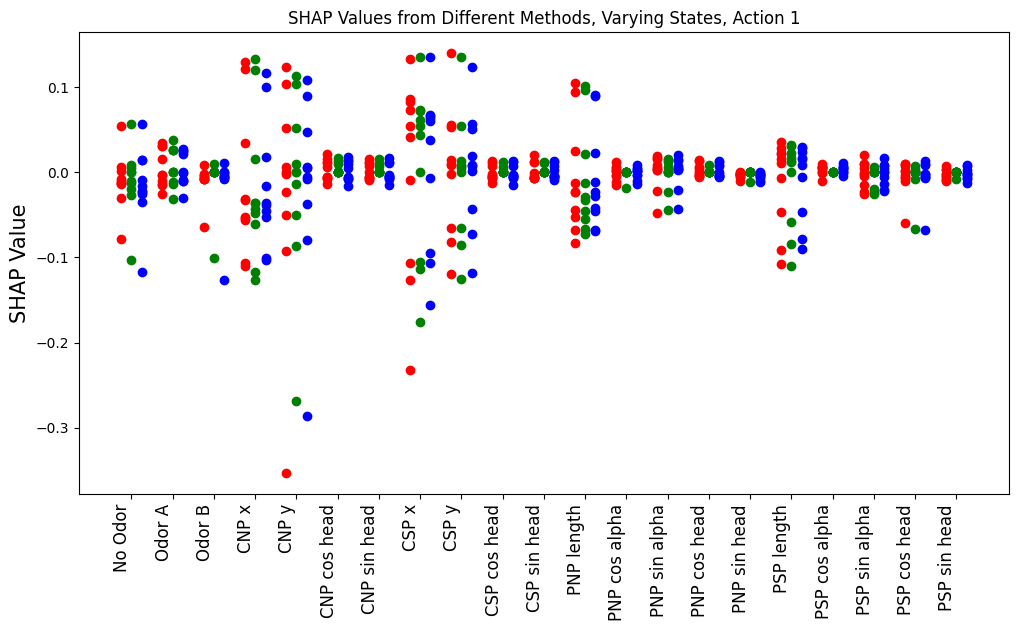

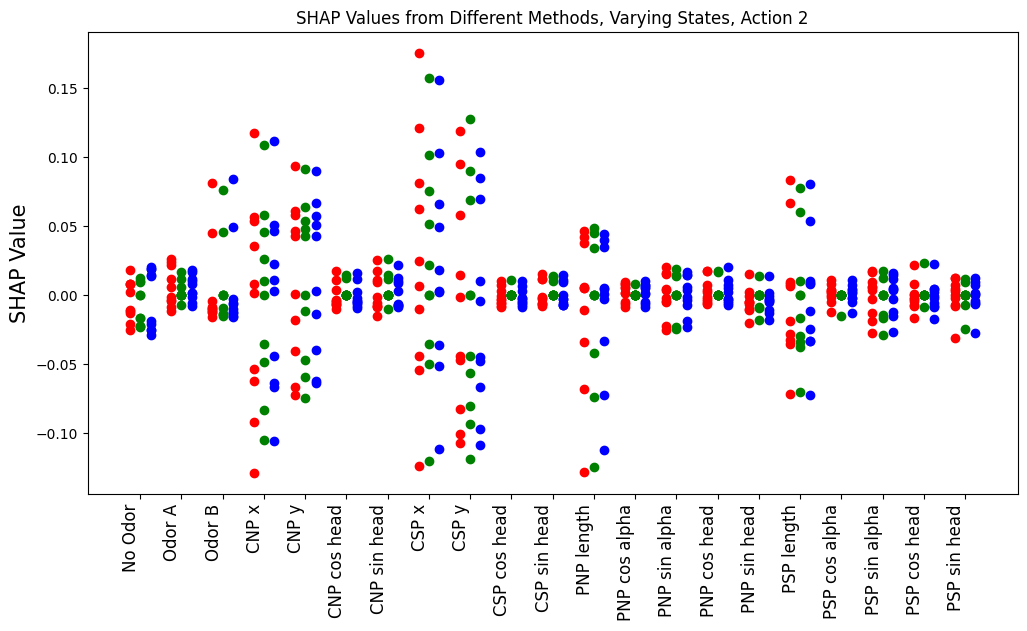

In [13]:
num_agents = 10
cat = data_dir_lr
replay_buffer_idx = 100 # this probably includes replay buffer + more; not exactly sure if impacts much though
action_idx = 0

colors = ['red', 'green', 'blue']

for action_idx in tqdm.tqdm(range(3)):

        fig, ax = plt.subplots(figsize=(12,6))

        for i in range(num_agents):
                
                # Loading Agent Model
                model_path = cat / f'trained-agent-state-{i}.pt'
                model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
                model.eval()
                wrapped_model = WrappedModel(model, device='cpu')

                if cat == data_dir_lr:
                        all_states = data_dict_lr['all_states']
                else:
                        all_states = data_dict_ew['all_states']
                        
                agent_eps = all_states[i]
                replay_buffer_ep = agent_eps[:replay_buffer_idx]
                replay_buffer_states = [state for episode in replay_buffer_ep for state in episode]
                assert len(replay_buffer_states) > 5000

                background_data = random.sample(replay_buffer_states, k=1000) # CONSIDER THE SAMPLING METHOD / SIZE
                # Assume background_data is a list of 1D state tensors
                background_tensor = torch.stack(background_data)           # shape: (N, num_features)
                background_numpy = background_tensor.cpu().numpy()         # convert to NumPy

                grad_explainer = shap.GradientExplainer(model, background_tensor)
                kern_explainer = shap.KernelExplainer(wrapped_model, background_numpy) # KernelExplainer requires NumPy support
                deep_explainer = shap.DeepExplainer(model, background_tensor)

                # Manipulate this if you want a fixed state
                non_replay_buffer_ep = agent_eps[replay_buffer_idx:]
                non_replay_buffer_states = [state for episode in non_replay_buffer_ep for state in episode]
                random_state_t = torch.stack(random.sample(non_replay_buffer_states, k=1)) # you could explain batches of states ; increase k value
                random_state_n = random_state_t.numpy()

                grad_values = grad_explainer.shap_values(random_state_t)[0]
                kern_values = kern_explainer.shap_values(random_state_n)[0] 
                deep_values = deep_explainer.shap_values(random_state_t)[0]

                action_values = []

                for j in range(21):
                        input_vals = []
                        input_vals.append(grad_values[j][action_idx])
                        input_vals.append(kern_values[j][action_idx])
                        input_vals.append(deep_values[j][action_idx])
                        action_values.append(input_vals)

                data = np.array(action_values)
                num_groups = len(data)
                num_bars = data.shape[1]

                x = np.arange(num_groups)  # positions for groups

                # Plot each of the 3 bars per group
                for k in range(num_bars):
                        ax.scatter(x + k * 0.25, data[:, k], label=f'SHAP {i}', color=colors[k])
        x_ticks = list(x + 0.25)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(labels=input_labels, rotation=90, ha='right', fontsize=12)
        ax.set_ylabel('SHAP Value', fontsize=15)
        ax.set_title(f'SHAP Values from Different Methods, Varying States, Action {action_idx}')
        fig.savefig(f'figures/shapdiffmethodvarystate{action_idx}.png', dpi=300, bbox_inches='tight')
        fig.show()

### SHAP Values, Different Methods, Fixed State

  0%|          | 0/3 [00:00<?, ?it/s]Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_87662/364111696.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 33%|███▎      | 1/3 [00:50<01:41, 50.52s/it]Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_87662/364111696.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 67%|██████▋   | 2/3 [01:40<00:50, 50.20s/it]Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_87662/364111696.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
100%|██████████| 3/3 [02:31<00:00, 50.59s/it]


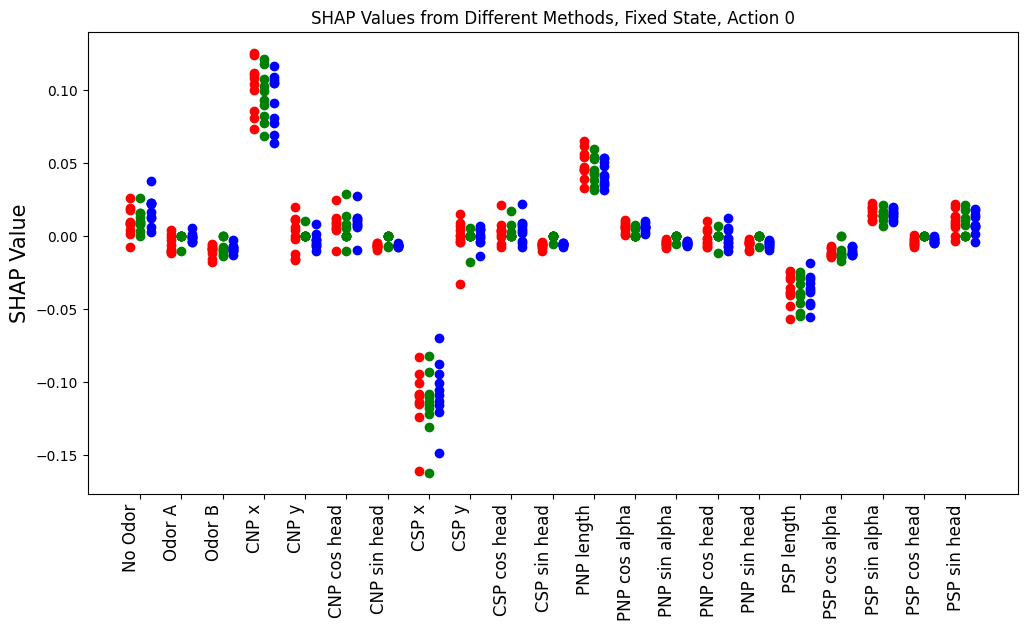

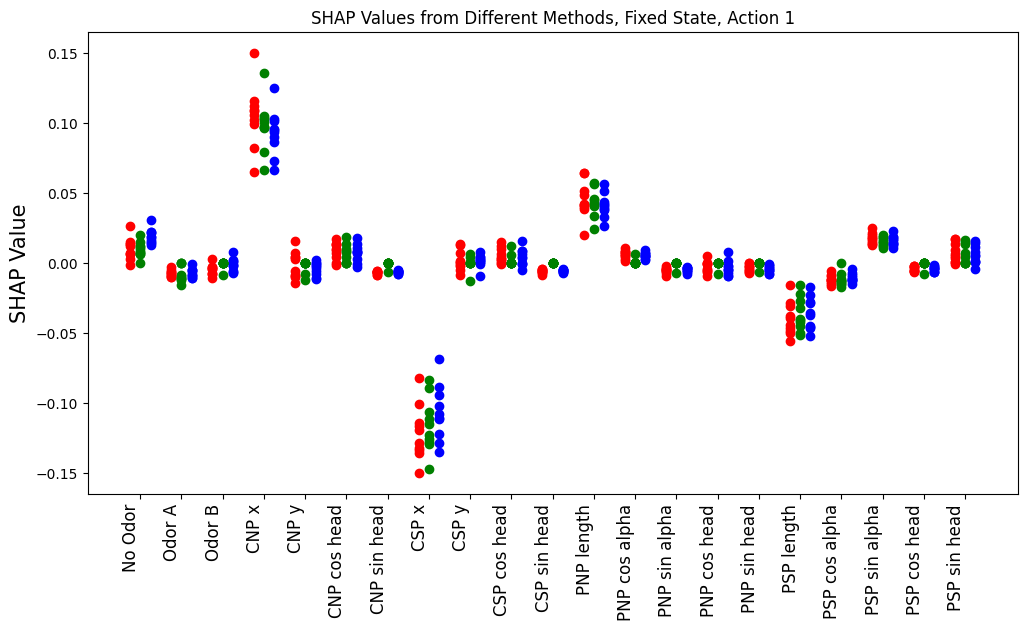

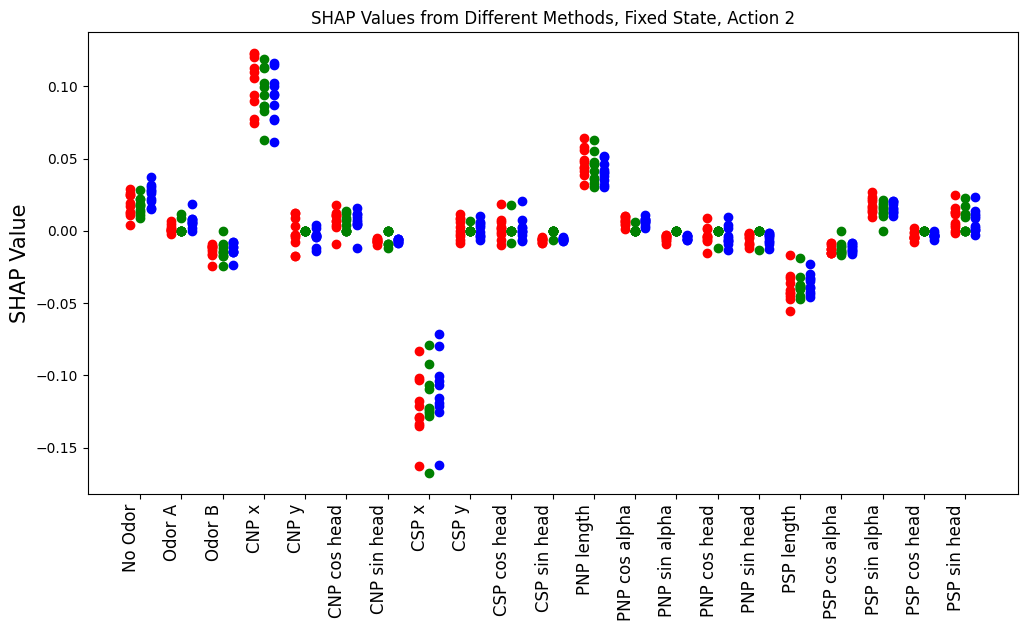

In [14]:
num_agents = 10
cat = data_dir_lr
replay_buffer_idx = 100 # this probably includes replay buffer + more; not exactly sure if impacts much though
action_idx = 0

colors = ['red', 'green', 'blue']

for action_idx in tqdm.tqdm(range(3)):

        fig, ax = plt.subplots(figsize=(12,6))

        for i in range(num_agents):
                
                # Loading Agent Model
                model_path = cat / f'trained-agent-state-{i}.pt'
                model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
                model.eval()
                wrapped_model = WrappedModel(model, device='cpu')

                if cat == data_dir_lr:
                        all_states = data_dict_lr['all_states']
                else:
                        all_states = data_dict_ew['all_states']
                        
                agent_eps = all_states[i]
                replay_buffer_ep = agent_eps[:replay_buffer_idx]
                replay_buffer_states = [state for episode in replay_buffer_ep for state in episode]
                assert len(replay_buffer_states) > 5000

                background_data = random.sample(replay_buffer_states, k=1000) # CONSIDER THE SAMPLING METHOD / SIZE
                # Assume background_data is a list of 1D state tensors
                background_tensor = torch.stack(background_data)           # shape: (N, num_features)
                background_numpy = background_tensor.cpu().numpy()         # convert to NumPy

                grad_explainer = shap.GradientExplainer(model, background_tensor)
                kern_explainer = shap.KernelExplainer(wrapped_model, background_numpy) # KernelExplainer requires NumPy support
                deep_explainer = shap.DeepExplainer(model, background_tensor)

                grad_values = grad_explainer.shap_values(state_fixed_tensor)[0]
                kern_values = kern_explainer.shap_values(state_fixed_tensor.numpy())[0] 
                deep_values = deep_explainer.shap_values(state_fixed_tensor)[0]

                action_values = []

                for j in range(21):
                        input_vals = []
                        input_vals.append(grad_values[j][action_idx])
                        input_vals.append(kern_values[j][action_idx])
                        input_vals.append(deep_values[j][action_idx])
                        action_values.append(input_vals)

                data = np.array(action_values)
                num_groups = len(data)
                num_bars = data.shape[1]

                x = np.arange(num_groups)  # positions for groups

                # Plot each of the 3 bars per group
                for k in range(num_bars):
                        ax.scatter(x + k * 0.25, data[:, k], label=f'SHAP {i}', color=colors[k])
        x_ticks = list(x + 0.25)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(labels=input_labels, rotation=90, ha='right', fontsize=12)
        ax.set_ylabel('SHAP Value', fontsize=15)
        ax.set_title(f'SHAP Values from Different Methods, Fixed State, Action {action_idx}')
        fig.savefig(f'figures/shapdiffmethodfixstate{action_idx}.png', dpi=300, bbox_inches = 'tight')
        fig.show()

## Comparing Agent Conditions

In [21]:
state_fixed = {'cue': torch.tensor(1), 'x': -2, 'y': 1, 'direction': 270}
state_fixed_tensor = DuplicatedCoordsEnv.conv_dict_to_flat_duplicated_coords(self=env, state=state_fixed).unsqueeze(0)
print(state_fixed_tensor)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  4.0000e+00,  1.0000e+00,
          1.0000e+00, -1.1925e-08,  0.0000e+00,  3.0000e+00, -1.0000e+00,
          1.1925e-08,  4.1231e+00,  9.7014e-01,  2.4254e-01,  9.7014e-01,
         -2.4254e-01,  3.0000e+00, -4.3711e-08,  1.0000e+00,  1.9471e-07,
          1.0000e+00]])


In [16]:
input_labels = ['No Odor', 'Odor A', 'Odor B', 'CNP x', 'CNP y', 'CNP cos head', 'CNP sin head', 'CSP x', 'CSP y', 'CSP cos head', 'CSP sin head',
                'PNP length', 'PNP cos alpha', 'PNP sin alpha', 'PNP cos head', 'PNP sin head', 'PSP length', 'PSP cos alpha', 'PSP sin alpha',
                'PSP cos head', 'PSP sin head']
print(len(input_labels))

21


In [17]:
state_list = []

In [29]:
state_list.append(state_fixed_tensor)

In [30]:
print(state_list)

[tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,  4.0000e+00,
          8.7423e-08,  1.0000e+00,  3.0000e+00,  0.0000e+00, -8.7423e-08,
         -1.0000e+00,  4.1231e+00,  2.4254e-01,  9.7014e-01,  9.7014e-01,
          2.4254e-01,  3.0000e+00,  1.0000e+00,  0.0000e+00, -4.3711e-08,
         -1.0000e+00]])]


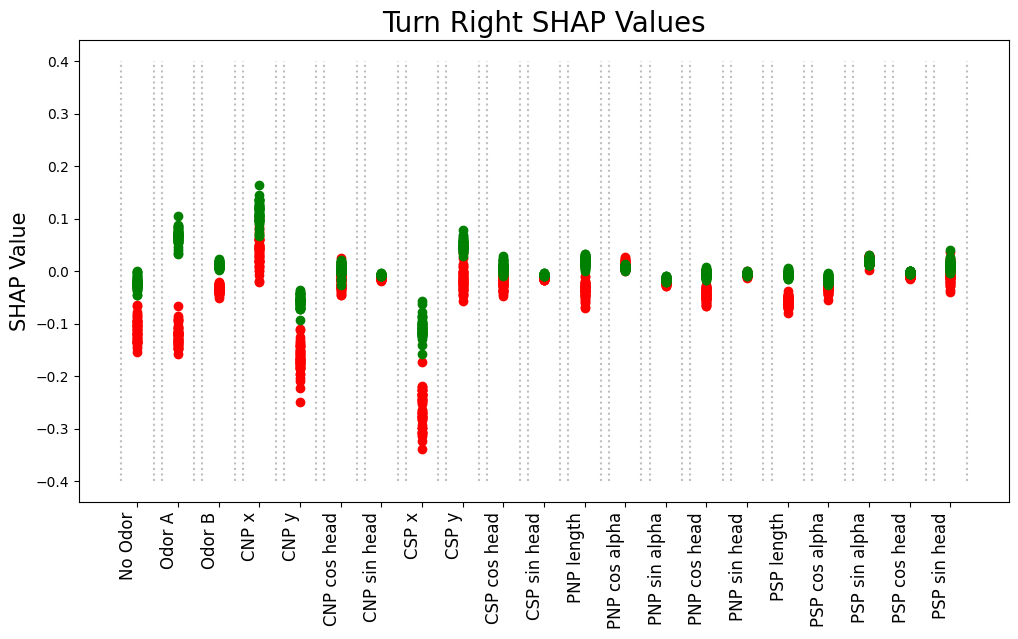

In [24]:
model = DQN(n_observations, n_actions, n_units)

num_agents = 50
replay_buffer_idx = 100 # this probably includes replay buffer + more; not exactly sure if impacts much though

colors = ['red', 'green', 'blue']

fig, ax = plt.subplots(figsize=(12,6))


j = 0
for cat in [data_dir_lr, data_dir_ew]:
#for fix_state in state_list:
    for i in range(num_agents):
            
            # Loading Agent Model
            model_path = cat / f'trained-agent-state-{i}.pt'
            model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
            model.eval()
            wrapped_model = WrappedModel(model, device='cpu')

            if cat == data_dir_lr:
                    all_states = data_dict_lr['all_states']
            else:
                    all_states = data_dict_ew['all_states']
                    
            agent_eps = all_states[i]
            replay_buffer_ep = agent_eps[:replay_buffer_idx]
            replay_buffer_states = [state for episode in replay_buffer_ep for state in episode]
            assert len(replay_buffer_states) > 5000

            background_data = random.sample(replay_buffer_states, k=500) # CONSIDER THE SAMPLING METHOD / SIZE
            # Assume background_data is a list of 1D state tensors
            background_tensor = torch.stack(background_data)           # shape: (N, num_features)

            deep_explainer = shap.DeepExplainer(model, background_tensor)

            deep_values = deep_explainer.shap_values(state_fixed_tensor)[0]

            data = np.array(deep_values)
            num_groups = len(data)
            num_bars = data.shape[1]

            x = np.arange(num_groups)  # positions for groups


            ax.scatter(x+0.25, data[:, 2], color=colors[j])
        #     # Plot each of the 3 bars per group
        #     for k in range(num_bars):
        #             ax.scatter(x + k * 0.25, data[:, k], color=colors[j])
    j += 1




x_ticks = list(x + 0.25)
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels=input_labels, rotation=90, ha='right', fontsize=12)

# Add vertical lines around each dot "bar" with a small offset
bar_width = 0.4  # half-width on each side
for xi in x_ticks:
    ax.vlines(xi - bar_width, ymin=-0.4, ymax=0.4, colors='gray', linestyles='dotted', alpha=0.5)
    ax.vlines(xi + bar_width, ymin=-0.4, ymax=0.4, colors='gray', linestyles='dotted', alpha=0.5)


ax.set_ylabel('SHAP Value', fontsize=15)
ax.set_title('Turn Right SHAP Values', fontsize=20)
fig.savefig('figures/shap2.png', dpi=300, bbox_inches = 'tight')
# fig.show()

## Fishing for States with High SHAP Values

In [63]:
model = DQN(n_observations, n_actions, n_units)

num_agents = 10
cat = data_dir_lr
shap_threshold = 0.3

replay_buffer_idx = 100 # this probably includes replay buffer + more; not exactly sure if impacts much though

acquired_states = []

all_significant_shap = []

for i in range(num_agents):

    # Loading Agent Model
    model_path = cat / f'trained-agent-state-{i}.pt'
    model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
    model.eval()

    if cat == data_dir_lr:
        all_states = data_dict_lr['all_states']
    else:
        all_states = data_dict_ew['all_states']

    agent_eps = all_states[i]
    replay_buffer_ep = agent_eps[:replay_buffer_idx]
    replay_buffer_states = [state for episode in replay_buffer_ep for state in episode]

    non_replay_buffer_ep = agent_eps[replay_buffer_idx:-1] # -1 to ensure we don't get terminal states
    non_replay_buffer_states = [state for episode in non_replay_buffer_ep for state in episode]

    fifty_state_sample = random.sample(non_replay_buffer_states, k=50) # let's take 50 random states to compute SHAP values for

    background_data = random.sample(replay_buffer_states, k=1000) # CONSIDER THE SAMPLING METHOD / SIZE
    # Assume background_data is a list of 1D state tensors
    background_tensor = torch.stack(background_data)           # shape: (N, num_features)

    deep_explainer = shap.DeepExplainer(model, background_tensor)

    for sample_state in fifty_state_sample:
        sample_state_tensor = torch.unsqueeze(sample_state, dim=0)
        deep_values = deep_explainer.shap_values(sample_state_tensor)[0]

        sig_shap = [(i, j, val) for i, feature in enumerate(deep_values)
                     for j, val in enumerate(feature)
                     if val > shap_threshold or val < -shap_threshold]

        if len(sig_shap) > 0:
            acquired_states.append(sample_state)
            all_significant_shap.append(sig_shap)
print(len(acquired_states))
print(acquired_states)
print('---------------------------------------')
print(len(all_significant_shap))
print(all_significant_shap)

4
[tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00,  4.0000e+00,  1.0000e+00,
         1.0000e+00, -4.8876e-07,  0.0000e+00,  3.0000e+00, -1.0000e+00,
         4.8876e-07,  4.1231e+00,  9.7014e-01,  2.4254e-01,  9.7014e-01,
        -2.4254e-01,  3.0000e+00, -4.3711e-08,  1.0000e+00,  4.3313e-07,
         1.0000e+00]), tensor([ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,  4.0000e+00,
        -1.0000e+00,  4.3711e-08,  3.0000e+00,  0.0000e+00,  1.0000e+00,
        -4.3711e-08,  4.1231e+00,  2.4254e-01,  9.7014e-01, -2.4254e-01,
         9.7014e-01,  3.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
        -4.3711e-08]), tensor([ 0.0000e+00,  0.0000e+00,  1.0000e+00,  4.0000e+00,  0.0000e+00,
        -0.0000e+00, -1.0000e+00,  0.0000e+00,  4.0000e+00,  0.0000e+00,
         1.0000e+00,  4.0000e+00,  1.0000e+00,  0.0000e+00, -4.3711e-08,
        -1.0000e+00,  4.0000e+00, -4.3711e-08,  1.0000e+00,  1.0000e+00,
         0.0000e+00]), tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.00

In [64]:
acquired_states_orig = []

for state in acquired_states:
    agent_north_cart = [state[3], state[4], state[5], state[6]]
    agent_orig_state = env.conv_north_cartesian2orig(coords_orig=agent_north_cart)
    acquired_states_orig.append(agent_orig_state)

In [65]:
print(acquired_states_orig)

[tensor([ -2.0000,   1.0000, 270.0000]), tensor([ 1., -2., 90.]), tensor([-2.,  2.,  0.]), tensor([ 2., -2., 90.])]


In [66]:
print(all_significant_shap)

[[(7, 2, np.float64(-0.3026707172393799))], [(8, 0, np.float64(-0.315552294254303))], [(4, 1, np.float64(-0.314309686422348))], [(3, 2, np.float64(-0.3052227199077606))]]


In [ ]:
# [tensor([ -2.0000,   1.0000, 270.0000]), tensor([ 1., -2., 90.]), tensor([ 1., -2., 90.]), tensor([-2.,  2.,  0.]), tensor([-2.,  2.,  0.]), tensor([ -1.0000,   2.0000, 270.0000]), tensor([ -1.0000,   2.0000, 270.0000]), tensor([  2.0000,  -2.0000, 180.0000]), tensor([ -1.0000,   2.0000, 270.0000]), tensor([ 2., -2., 90.])]
# [[(7, 2, np.float64(-0.3125040829181671))], [(8, 0, np.float64(-0.3032386600971222))], [(8, 0, np.float64(-0.3032386600971222))], [(4, 1, np.float64(-0.3121131360530853))], [(4, 1, np.float64(-0.30624058842658997))], [(4, 0, np.float64(-0.3374691605567932))], [(4, 0, np.float64(-0.3374691605567932))], [(8, 1, np.float64(-0.3165739178657532))], [(4, 0, np.float64(-0.3004162013530731))], [(3, 2, np.float64(-0.3148442804813385))]]

# [tensor([-2.,  2.,  0.]), tensor([ 2., -2., 90.]), tensor([-2.,  2.,  0.]), tensor([-2.,  2.,  0.]), tensor([ 2., -2., 90.]), tensor([  2.0000,  -2.0000, 180.0000]), tensor([ 2., -2., 90.]), tensor([ 2., -2., 90.])]
# [[(4, 1, np.float64(-0.30845358967781067))], [(3, 2, np.float64(-0.32297447323799133))], [(4, 1, np.float64(-0.30985814332962036))], [(4, 1, np.float64(-0.34486502408981323))], [(3, 2, np.float64(-0.3035225570201874))], [(8, 1, np.float64(-0.30898991227149963))], [(8, 0, np.float64(-0.3012641370296478))], [(3, 2, np.float64(-0.31333741545677185))]]

# [tensor([ -2.0000,   1.0000, 270.0000]), tensor([ 1., -2., 90.]), tensor([-2.,  2.,  0.]), tensor([ 2., -2., 90.])]
# [[(7, 2, np.float64(-0.3026707172393799))], [(8, 0, np.float64(-0.315552294254303))], [(4, 1, np.float64(-0.314309686422348))], [(3, 2, np.float64(-0.3052227199077606))]]































## Activation Analysis

In [84]:
def get_single_activation(net, input_state, layer_index):
    """
    Extract activation from a specific layer for a single input.
    
    Args:
        net: The trained DQN model.
        input_state: The input tensor of shape (1, input_dim).
        layer_index: Index of the layer in net.mlp to extract activation from.
    
    Returns:
        Tensor of activations from the selected layer.
    """
    activations = {}

    def hook(module, input, output):
        activations['output'] = output.detach()

    # Register hook only on the specified layer
    handle = list(net.mlp.children())[layer_index].register_forward_hook(hook)

    # Forward pass
    with torch.no_grad():
        net(input_state)

    # Clean up the hook
    handle.remove()

    return activations['output']


In [10]:
lr_net = data_dict_lr['net']
ew_net = data_dict_ew['net']

In [11]:
    # DQN(
    #   (mlp): Sequential(
    #     (0): Linear(in_features=21, out_features=512, bias=True)
    #     (1): Linear(in_features=512, out_features=512, bias=True)
    #     (2): ReLU()
    #     (3): Linear(in_features=512, out_features=512, bias=True)
    #     (4): ReLU()
    #     (5): Linear(in_features=512, out_features=512, bias=True)
    #     (6): ReLU()
    #     (7): Linear(in_features=512, out_features=3, bias=True)
    #   )
    # )

In [12]:
state_fixed = {'cue': torch.tensor(1), 'x': -2, 'y': 1, 'direction': 270}
state_fixed_tensor = DuplicatedCoordsEnv.conv_dict_to_flat_duplicated_coords(self=env, state=state_fixed)
print(state_fixed_tensor)

tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00,  4.0000e+00,  1.0000e+00,
         1.0000e+00, -1.1925e-08,  0.0000e+00,  3.0000e+00, -1.0000e+00,
         1.1925e-08,  4.1231e+00,  9.7014e-01,  2.4254e-01,  9.7014e-01,
        -2.4254e-01,  3.0000e+00, -4.3711e-08,  1.0000e+00,  1.9471e-07,
         1.0000e+00])


In [119]:
layer_idx = 0

lr_activations = get_single_activation(lr_net, state_fixed_tensor, layer_index=layer_idx)
ew_activations = get_single_activation(ew_net, state_fixed_tensor, layer_index=layer_idx)

In [116]:
def plot_activations_bar(activations):
    activations = activations.squeeze().cpu().numpy()
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(activations)), activations)
    plt.xlabel("Neuron Index")
    plt.ylabel("Activation Value")
    plt.title("Neuron Activations")
    plt.tight_layout()
    plt.show()

In [118]:
def plot_activations_overlay_bar(activation_a, activation_b, label_a='Agent A', label_b='Agent B'):
    a = activation_a.squeeze().cpu().numpy()
    b = activation_b.squeeze().cpu().numpy()
    indices = np.arange(len(a))
    width = 0.4
    plt.figure(figsize=(14, 5))
    plt.bar(indices - width/2, a, width=width, label=label_a, alpha=0.7)
    plt.bar(indices + width/2, b, width=width, label=label_b, alpha=0.7)
    plt.xlabel("Neuron Index")
    plt.ylabel("Activation Value")
    plt.title("Neuron Activations Side-by-Side")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [121]:
def plot_sorted_overlay_bar(agent_a_act, agent_b_act, label_a='Agent A', label_b='Agent B'):
    a = agent_a_act.squeeze().cpu().numpy()
    b = agent_b_act.squeeze().cpu().numpy()
    
    # 1. Get sorting indices by Agent A activations (descending order)
    sorted_indices = np.argsort(a)[::-1]
    
    # 2. Reorder activations by those indices
    a_sorted = a[sorted_indices]
    b_sorted = b[sorted_indices]
    
    # 3. Plot side-by-side bars using sorted order
    indices = np.arange(len(a_sorted))
    width = 0.4
    
    plt.figure(figsize=(14,5))
    plt.bar(indices - width/2, a_sorted, width=width, label=label_a, alpha=0.7)
    plt.bar(indices + width/2, b_sorted, width=width, label=label_b, alpha=0.7)
    
    plt.xlabel("Neuron Rank (sorted by Agent A activation)")
    plt.ylabel("Activation Value")
    plt.title("Sorted Activations: Agent A vs Agent B")
    plt.legend()
    plt.tight_layout()
    plt.show()


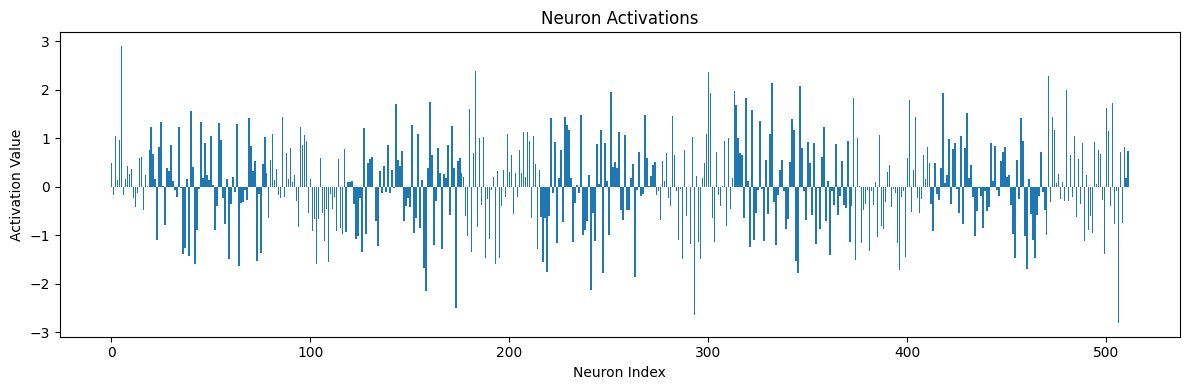

In [117]:
plot_activations_bar(lr_activations)

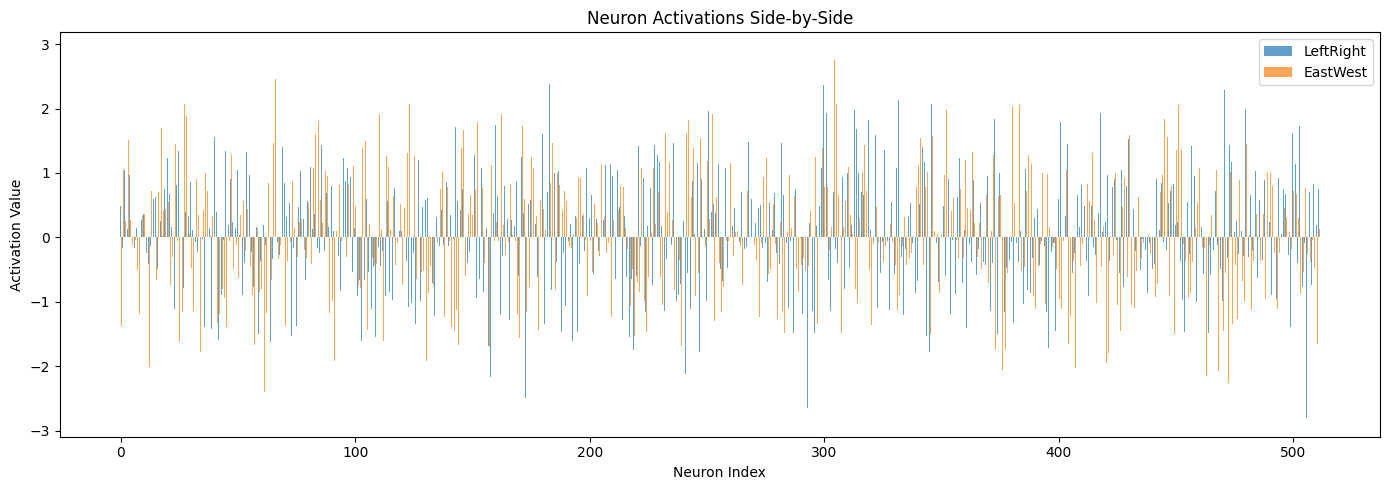

In [120]:
plot_activations_overlay_bar(lr_activations, ew_activations, 'LeftRight', 'EastWest')

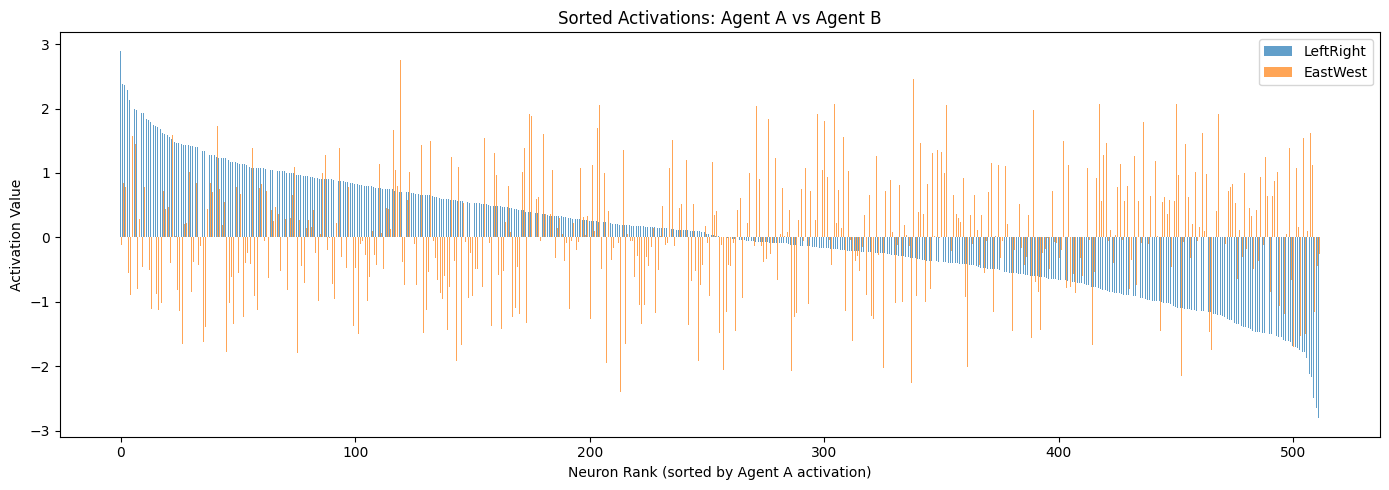

In [122]:
plot_sorted_overlay_bar(lr_activations, ew_activations, 'LeftRight', 'EastWest')

## Getting Activations for a Bunch of States by Layer

In [15]:
agent_idx = 0
replay_buffer_idx = 100

cat = data_dir_lr

if cat == data_dir_lr:
    all_states = data_dict_lr['all_states']
else:
    all_states = data_dict_ew['all_states']

agent_eps = all_states[agent_idx]

replay_buffer_ep = agent_eps[:replay_buffer_idx]
replay_buffer_states = [state for episode in replay_buffer_ep for state in episode]

non_replay_buffer_ep = agent_eps[replay_buffer_idx:] 
non_replay_buffer_states = [state for episode in non_replay_buffer_ep for state in episode]

all_agent_states = [state for episode in agent_eps for state in episode]

state_samples = random.sample(all_agent_states, k=500)

In [16]:
"""
Function for converting angle degree to cardinal direction
"""
def degrees_to_cardinal(degree):
    # Normalize the degree to [0, 360)
    degree = degree % 360

    # Define the mapping
    directions = {
        0: 'N',
        90: 'E',
        180: 'S',
        270: 'W'
    }

    # Find the closest cardinal angle
    closest = min(directions.keys(), key=lambda x: abs(x - degree))
    return directions[closest]

In [17]:
def convert_state_sample_to_orig_sample(state_sample):
    orig_state_samples = []
    for state in state_sample:

        if state[0].item() == 1:
            odor_cue = 'No Odor'
        elif state[1].item() == 1:
            odor_cue = 'Odor A'
        else:
            odor_cue = 'Odor B'

        coords_orig = env.conv_north_cartesian2orig(state[3:7]).tolist()
        coords_orig.insert(0, odor_cue)
        
        head_deg = coords_orig[3]
        head_cardinal = degrees_to_cardinal(head_deg)
        coords_orig[3] = head_cardinal

        orig_state_samples.append(coords_orig)
    return orig_state_samples

In [18]:
orig_samples = convert_state_sample_to_orig_sample(state_sample=state_samples)
print(orig_samples)

[['Odor A', -2.0, -2.0, 'S'], ['Odor A', 2.0, 2.0, 'N'], ['No Odor', 1.0, -2.0, 'S'], ['Odor A', -2.0, -1.0, 'W'], ['Odor B', -1.0, 0.0, 'S'], ['Odor A', 1.0, -1.0, 'W'], ['Odor A', 2.0, 1.0, 'N'], ['No Odor', -2.0, 2.0, 'N'], ['No Odor', -2.0, 2.0, 'N'], ['Odor A', -1.0, -1.0, 'S'], ['Odor A', 1.0, -1.0, 'W'], ['No Odor', 1.0, 1.0, 'N'], ['Odor B', -1.0, 2.0, 'N'], ['No Odor', -2.0, 2.0, 'N'], ['No Odor', 1.0, -1.0, 'N'], ['No Odor', -2.0, 1.0, 'N'], ['Odor A', 0.0, 0.0, 'S'], ['Odor A', -2.0, 2.0, 'W'], ['Odor A', -1.0, -2.0, 'S'], ['No Odor', -2.0, 2.0, 'N'], ['Odor A', 1.0, 1.0, 'N'], ['No Odor', -1.0, -1.0, 'W'], ['No Odor', 2.0, -1.0, 'E'], ['Odor B', 2.0, 0.0, 'E'], ['No Odor', -1.0, -1.0, 'E'], ['No Odor', 2.0, -1.0, 'S'], ['No Odor', -1.0, -1.0, 'S'], ['Odor B', 2.0, 2.0, 'N'], ['Odor A', -1.0, 2.0, 'W'], ['No Odor', -1.0, 1.0, 'W'], ['No Odor', -1.0, -1.0, 'N'], ['Odor A', -2.0, 0.0, 'N'], ['No Odor', -1.0, 0.0, 'S'], ['No Odor', -2.0, 2.0, 'W'], ['No Odor', 0.0, 1.0, 'E'], [

In [19]:
metadata = {
    "odor": [],
    "x": [],
    "y": [],
    "grid_pos": [],
    "head_dir": [],
    # You can add more fields like distance_to_port or shap_action later
}

for state in orig_samples:
    metadata["odor"].append(state[0])
    metadata["x"].append(state[1])
    metadata["y"].append(state[2])
    metadata["grid_pos"].append((state[1], state[2]))
    metadata["head_dir"].append(state[3])

metadata_df = pd.DataFrame(metadata)
print(metadata_df.to_string())

        odor    x    y      grid_pos head_dir
0     Odor A -2.0 -2.0  (-2.0, -2.0)        S
1     Odor A  2.0  2.0    (2.0, 2.0)        N
2    No Odor  1.0 -2.0   (1.0, -2.0)        S
3     Odor A -2.0 -1.0  (-2.0, -1.0)        W
4     Odor B -1.0  0.0   (-1.0, 0.0)        S
5     Odor A  1.0 -1.0   (1.0, -1.0)        W
6     Odor A  2.0  1.0    (2.0, 1.0)        N
7    No Odor -2.0  2.0   (-2.0, 2.0)        N
8    No Odor -2.0  2.0   (-2.0, 2.0)        N
9     Odor A -1.0 -1.0  (-1.0, -1.0)        S
10    Odor A  1.0 -1.0   (1.0, -1.0)        W
11   No Odor  1.0  1.0    (1.0, 1.0)        N
12    Odor B -1.0  2.0   (-1.0, 2.0)        N
13   No Odor -2.0  2.0   (-2.0, 2.0)        N
14   No Odor  1.0 -1.0   (1.0, -1.0)        N
15   No Odor -2.0  1.0   (-2.0, 1.0)        N
16    Odor A  0.0  0.0    (0.0, 0.0)        S
17    Odor A -2.0  2.0   (-2.0, 2.0)        W
18    Odor A -1.0 -2.0  (-1.0, -2.0)        S
19   No Odor -2.0  2.0   (-2.0, 2.0)        N
20    Odor A  1.0  1.0    (1.0, 1.

In [20]:
def get_layer_activations(net, input_states, layer_index):
    activations_list = []

    def hook(module, input, output):
        activations_list.append(output.detach().cpu().numpy().squeeze())

    # Register hook
    handle = list(net.mlp.children())[layer_index].register_forward_hook(hook)

    # Forward pass through each input state
    with torch.no_grad():
        for state in input_states:
            net(state)

    # Clean up hook
    handle.remove()

    # Stack into numpy array
    activations_array = np.stack(activations_list)  # Shape: (500, 512)

    return activations_array


In [53]:
cat = data_dir_ew

if cat == data_dir_lr:
    cat_label = 'L/R'
else:
    cat_label = 'E/W'

model = DQN(n_observations, n_actions, n_units)

model_path = cat / f'trained-agent-state-0.pt'
model.load_state_dict(torch.load(model_path, weights_only=False, map_location=torch.device('cpu')))
model.eval()

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=21, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [79]:
layer_idx = 7

layer_activations = get_layer_activations(model, state_samples, layer_idx)

In [80]:
print(layer_activations.shape)

(500, 3)


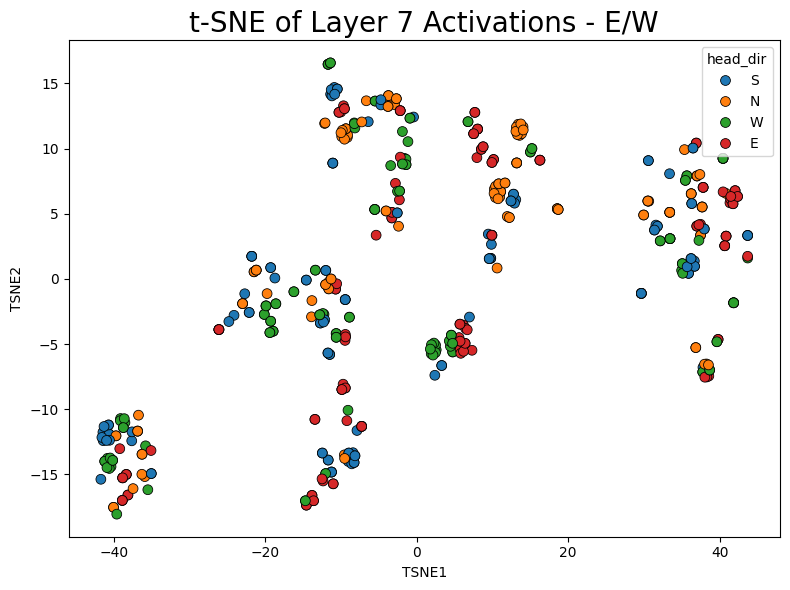

In [84]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='random', random_state=42)
activations_2d = tsne.fit_transform(layer_activations)  # Shape: (500, 2)

tsne_df = pd.DataFrame(activations_2d, columns=["TSNE1", "TSNE2"])
full_df = pd.concat([tsne_df, metadata_df], axis=1)


plt.figure(figsize=(8, 6))
sns.scatterplot(data=full_df, x="TSNE1", y="TSNE2", hue="head_dir", palette="tab10",s=50,edgecolor='k')
plt.title(f"t-SNE of Layer {layer_idx} Activations - {cat_label}", fontsize=20)
plt.tight_layout()
plt.savefig(f'figures/layer{layer_idx}EWHEADtSNE.png', dpi=300, bbox_inches='tight')
plt.show()

### Looping Over Agents

[[-0.75259435  0.24731912 -0.04950944 ... -2.107074    0.2955834
   0.7524451 ]
 [-0.7477163   0.07573317  0.04695529 ... -2.0358841   0.6088352
   0.48916227]
 [-1.226105    0.50706595  1.6215318  ...  0.3956318   0.7604729
   0.679989  ]
 ...
 [-1.915252    1.701761    0.23948395 ... -0.7823848   0.74119306
  -0.42378378]
 [-0.8302721   0.02051304  0.3211521  ... -1.6002271   0.29990473
   0.8937664 ]
 [-1.4506795   0.8251551   0.45807666 ... -0.18229462  0.44557598
   0.1780505 ]]


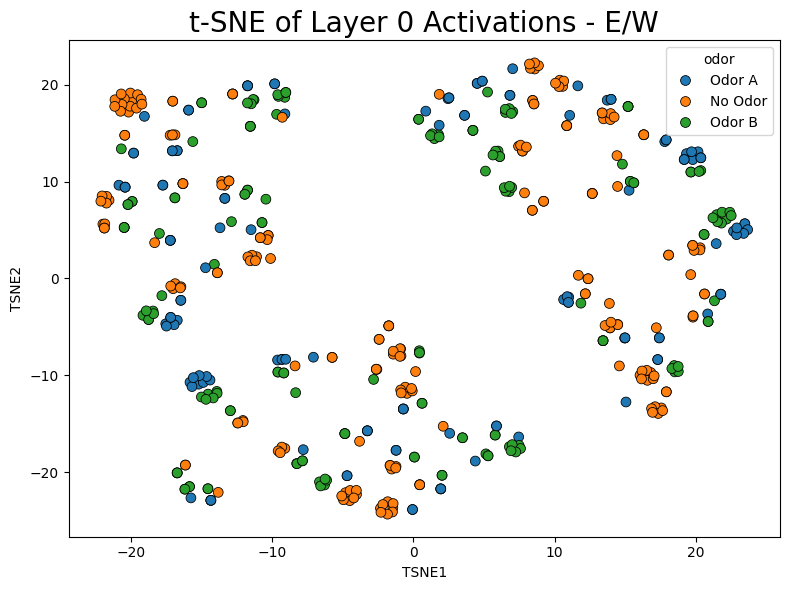

[[ 1.7264763  -1.2267795  -0.53391767 ...  2.251641    0.70707786
   0.6984836 ]
 [ 0.635734    0.60670817  0.09981424 ...  1.9308658   0.7799396
   0.8229294 ]
 [ 1.5041124  -0.6000657  -0.07392636 ...  2.0392947   0.45952404
   0.0364182 ]
 ...
 [ 2.1974986  -1.1131293  -0.28471965 ...  0.81012005 -0.81159955
  -0.61657214]
 [ 1.1783317  -0.48318627 -1.3918853  ...  0.35024324 -0.22417194
  -0.22561744]
 [ 1.5575978  -1.3772324  -1.1109871  ...  0.9113673   0.04528074
  -0.43227223]]


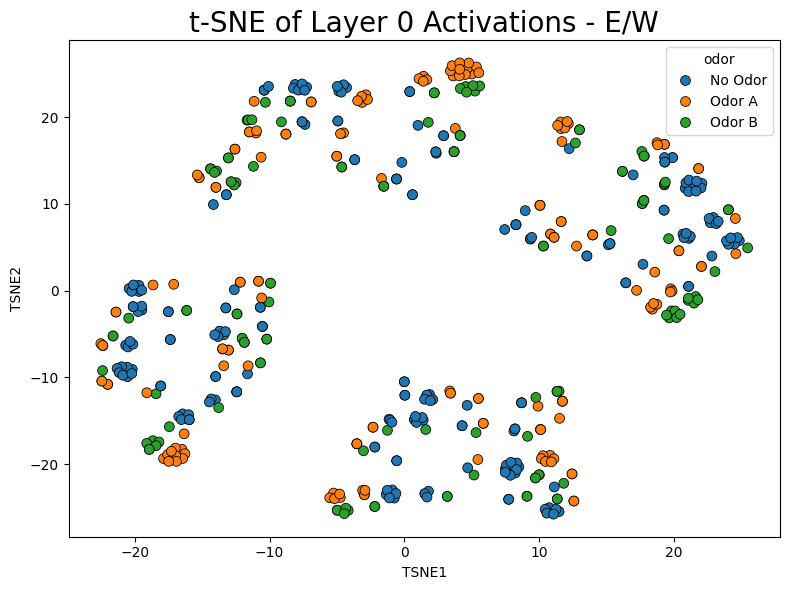

[[ 1.1685361  -0.64370155 -0.09567232 ...  0.14935274 -0.94855547
   1.1730552 ]
 [-0.17895658 -0.26607633 -0.30882898 ... -0.07207076 -0.71764445
   1.2761494 ]
 [ 0.79693854 -0.6883441   0.14848186 ... -0.07628162 -0.41023386
   0.4415946 ]
 ...
 [ 0.46287858 -0.11060045  0.6085472  ...  0.21692659 -2.0636315
   0.35208464]
 [-0.5153946  -0.72360486  0.02724065 ... -0.00550291 -1.9788505
   0.53695923]
 [-0.01193495 -1.0633624   0.12012948 ... -0.45524877 -1.2633737
   0.19164795]]


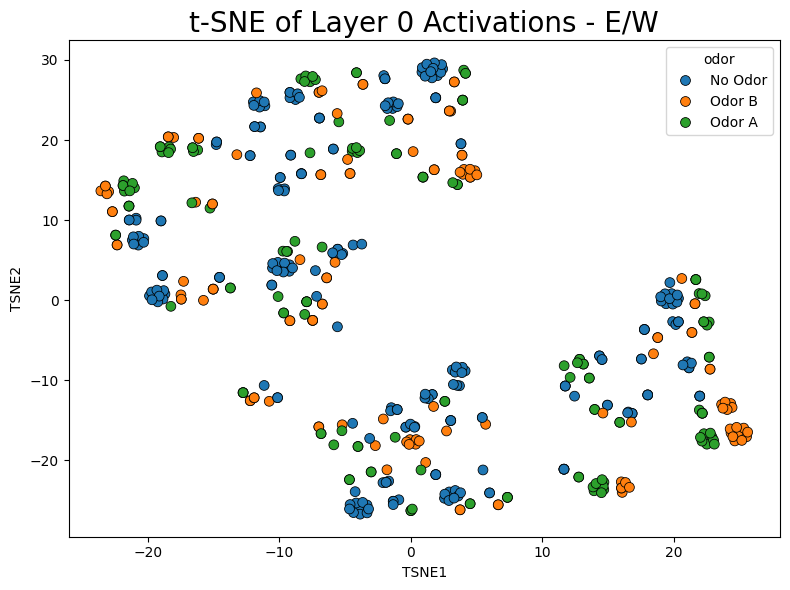

[[-0.08605406  0.03751275 -1.2591686  ...  0.51574236  0.10837495
   1.4875938 ]
 [-0.79243475  0.22317272 -0.1499597  ... -0.22537623  0.7777727
   1.1318611 ]
 [-1.4911425  -0.5994283  -0.13731694 ... -0.04953935  1.6029744
  -0.39270312]
 ...
 [-0.8531492  -0.8119912  -0.612757   ... -0.16065301  1.3546536
   0.53707093]
 [ 0.1492534   0.14600486 -0.8160858  ... -0.6954733   1.0934997
   1.3119782 ]
 [-1.4228355  -0.3357722  -0.05823609 ... -0.20002815  1.4361607
   0.19212605]]


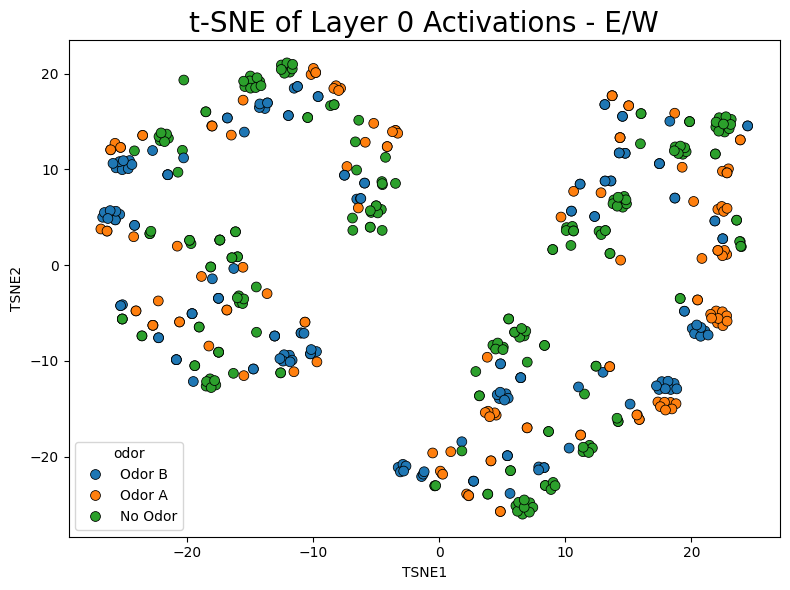

[[-2.8927355   1.5574511  -0.05885628 ...  0.97222877  0.84380364
  -0.50893825]
 [-2.719324    2.268698   -1.0494549  ... -0.5563937  -0.11976674
  -0.8861655 ]
 [-2.7429836   1.2993311  -0.14513907 ...  0.7365171   0.7455757
  -0.5144023 ]
 ...
 [-2.7429836   1.2993311  -0.14513907 ...  0.7365171   0.7455757
  -0.5144023 ]
 [-1.69913     1.2782416  -0.5618719  ...  0.62619466  0.78621906
  -0.6516498 ]
 [-2.2327704   3.0621734  -0.7605889  ... -0.15031312  0.07037529
  -0.9877672 ]]


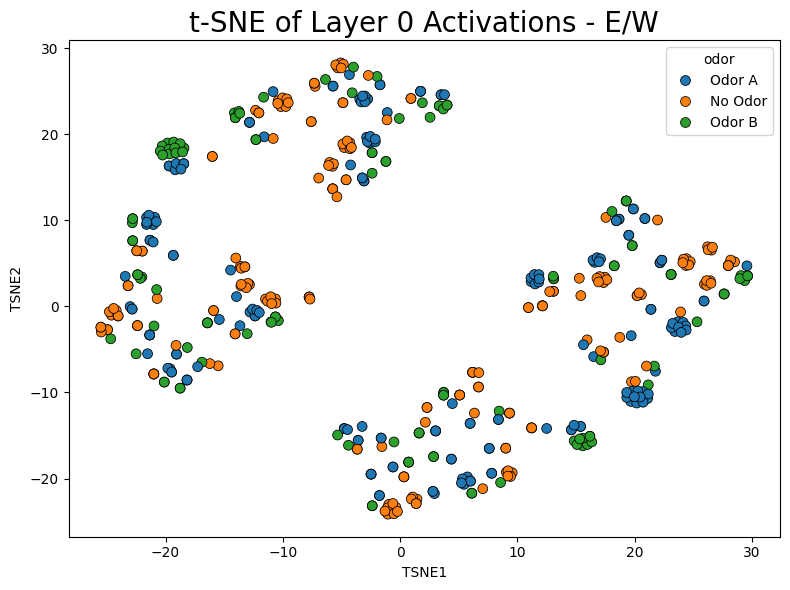

[[ 0.20005998 -0.9552214   0.54008865 ... -0.7303935  -0.05627579
  -1.4152566 ]
 [-0.06252304  0.16407913 -0.40364525 ...  1.2513025  -1.4575858
  -0.6998538 ]
 [-0.1217286  -0.0738933  -0.3563571  ...  0.78646654 -1.2309773
  -1.007232  ]
 ...
 [-0.53730667 -1.0868952  -0.18460059 ...  0.04957135 -0.45621312
  -1.2632577 ]
 [-0.96765155 -0.47742185 -0.84333134 ...  0.8854491  -1.7472541
  -1.820028  ]
 [ 0.46176392 -0.44612363 -0.5288838  ...  0.00202022 -1.0255123
  -0.40682578]]


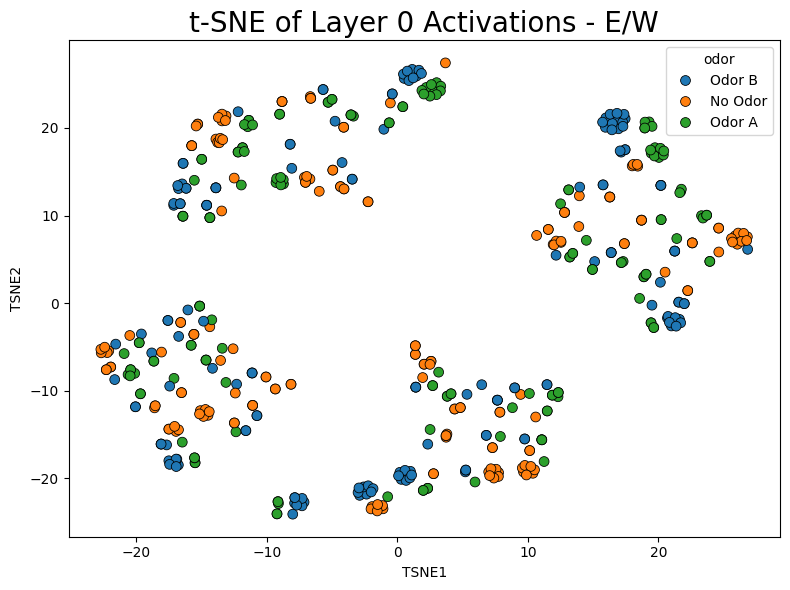

[[-0.65220964 -1.7173531   0.73579544 ...  0.7047485  -0.18712173
  -0.02104174]
 [ 0.15256375 -1.1992685   0.38964963 ...  0.42433393 -0.23465775
   0.21746938]
 [-1.1975974  -1.3332789   1.0074797  ...  0.98532414 -0.9461124
   1.0160974 ]
 ...
 [ 0.9762324  -0.62758774  0.7937865  ... -0.30358118 -0.34129113
   1.0546964 ]
 [-0.09406483 -0.6952659   1.4885455  ...  1.0758473   0.29235375
   0.2621202 ]
 [-0.17575634 -1.0849625   1.1871139  ...  0.3774407  -0.25166583
   0.9930178 ]]


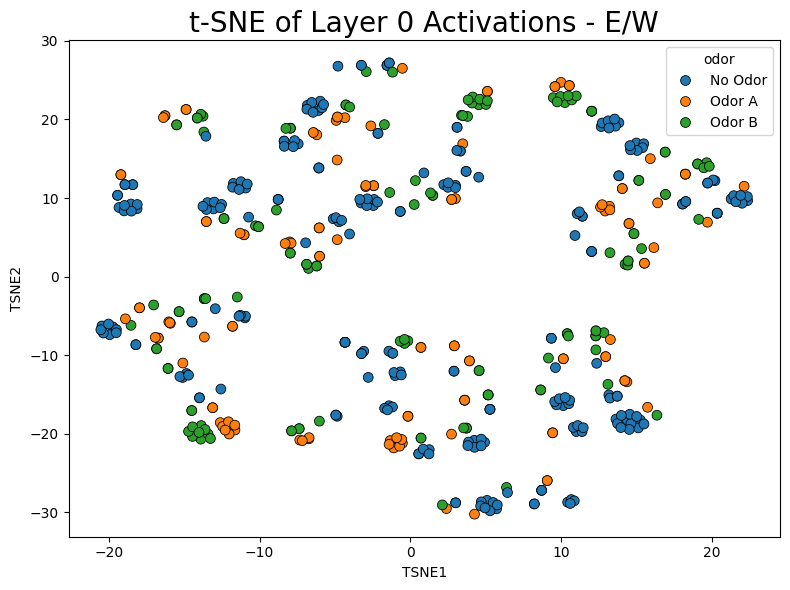

[[ 0.36223662  1.0490129   0.06422222 ...  0.17161757 -0.3693631
  -0.9071702 ]
 [ 0.5684288   0.27293813  0.19478996 ...  0.44005707  0.9355811
   0.26153508]
 [ 1.428362    1.266122    0.6737869  ...  0.5562908  -0.01547286
   0.14331594]
 ...
 [ 0.64094627  1.3685278   1.0251918  ...  0.77287334 -0.59747005
   0.14705965]
 [ 0.29999024  1.5097452   0.77491635 ...  0.7367802  -0.6053773
  -0.20831427]
 [ 0.8651097   1.6459349   0.828741   ...  0.9271021  -0.1291345
   0.6786381 ]]


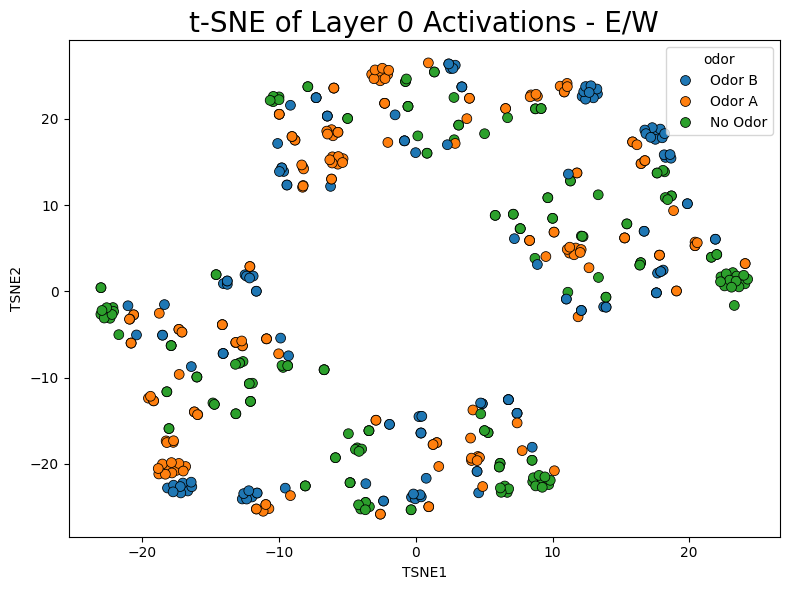

[[-0.6059893  -1.1982288   0.22222367 ...  0.33124942  1.7761704
   0.11213072]
 [ 0.5351509  -0.5236957   0.22427467 ...  0.52461576 -0.04759588
  -1.1613959 ]
 [-0.44566762 -1.1052371  -0.08636033 ...  0.5240727   0.5987239
  -0.34125108]
 ...
 [ 1.1311983  -0.1983324  -0.22030333 ...  0.21304105  0.32477963
  -1.0895003 ]
 [-0.60589653 -0.25184026 -1.1020019  ...  0.9644681   0.00476453
  -0.8909755 ]
 [ 0.39924175 -0.6087655  -0.14454894 ...  0.3140732   0.6712384
  -0.7275871 ]]


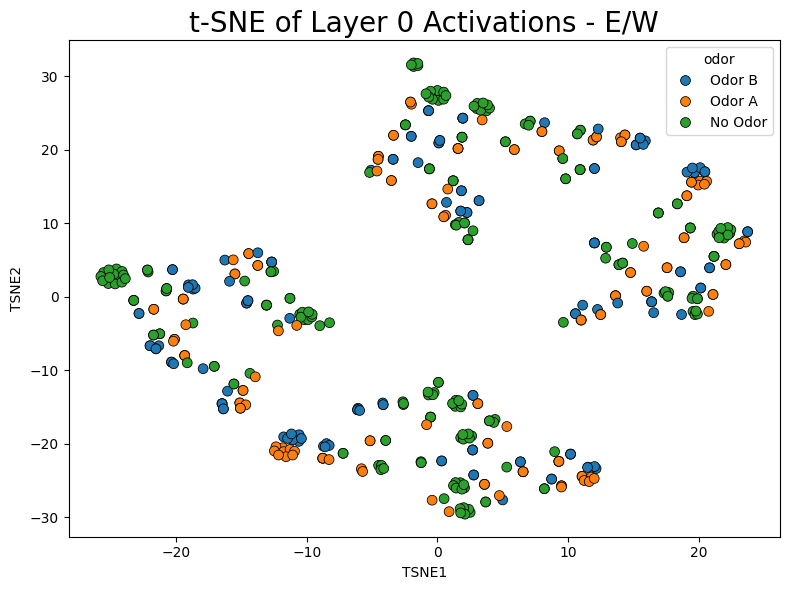

[[ 0.49514812 -0.02426699 -1.9739995  ...  1.3724018  -0.01844082
   1.5929476 ]
 [ 0.10889445  0.22025037 -2.2334294  ...  0.09690049 -0.3163474
   2.0258293 ]
 [ 0.10182206 -0.3855395  -1.9667115  ...  0.63159436  0.947902
   1.6956698 ]
 ...
 [ 0.16434084 -0.5619501  -1.8421773  ...  0.780932    0.9317275
   1.5386246 ]
 [ 0.0290806  -0.7561339  -1.7783809  ...  1.6428648   0.42128143
   1.7244432 ]
 [ 0.8637968  -0.35441774 -2.1323543  ...  0.6060166   0.21037492
   1.3854325 ]]


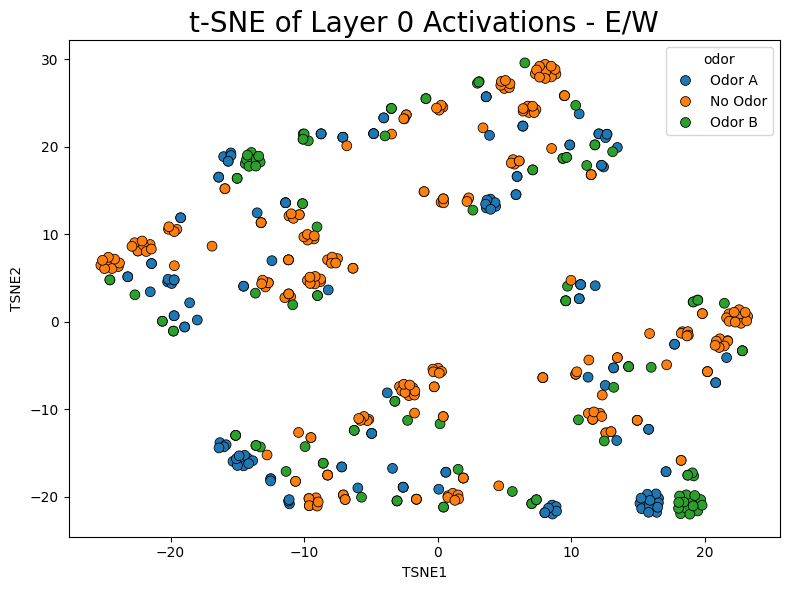

In [ ]:
num_agents = 10
replay_buffer_idx = 100
cat = data_dir_ew
layer_idx = 0

for agent_idx in range(num_agents):

    if cat == data_dir_lr:
        all_states = data_dict_lr['all_states']
        cat_label = 'L/R'
    else:
        all_states = data_dict_ew['all_states']
        cat_label = 'E/W'

    agent_eps = all_states[agent_idx]

    replay_buffer_ep = agent_eps[:replay_buffer_idx]
    replay_buffer_states = [state for episode in replay_buffer_ep for state in episode]

    non_replay_buffer_ep = agent_eps[replay_buffer_idx:] 
    non_replay_buffer_states = [state for episode in non_replay_buffer_ep for state in episode]

    all_agent_states = [state for episode in agent_eps for state in episode]

    state_samples = random.sample(all_agent_states, k=500) # for each agent we are getting a new set of 500 samples

    orig_samples = convert_state_sample_to_orig_sample(state_sample=state_samples)
    
    metadata = {
        "odor": [],
        "x": [],
        "y": [],
        "grid_pos": [],
        "head_dir": [],
        # You can add more fields like distance_to_port or shap_action later
    }

    for state in orig_samples:
        metadata["odor"].append(state[0])
        metadata["x"].append(state[1])
        metadata["y"].append(state[2])
        metadata["grid_pos"].append((state[1], state[2]))
        metadata["head_dir"].append(state[3])

    metadata_df = pd.DataFrame(metadata)
    #print(metadata_df.to_string())

    model = DQN(n_observations, n_actions, n_units)

    model_path = cat / f'trained-agent-state-{agent_idx}.pt'
    model.load_state_dict(torch.load(model_path, weights_only=False, map_location=torch.device('cpu')))
    model.eval()

    layer_activations = get_layer_activations(model, state_samples, layer_idx)
    print(layer_activations)

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='random', random_state=42)
    activations_2d = tsne.fit_transform(layer_activations)  # Shape: (500, 2)

    tsne_df = pd.DataFrame(activations_2d, columns=["TSNE1", "TSNE2"])
    full_df = pd.concat([tsne_df, metadata_df], axis=1)


    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=full_df, x="TSNE1", y="TSNE2", hue="odor", palette="tab10",s=50,edgecolor='k')
    plt.title(f"t-SNE of Layer {layer_idx} Activations - {cat_label}", fontsize=20)
    plt.tight_layout()
    plt.savefig(f'figures/EWODORtSNElayer{layer_idx}activations{agent_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [34]:
layer_activations

array([[ 1.4944853 ,  0.14360738,  1.7680684 , ...,  0.27776372,
         0.35632268, -2.1483319 ],
       [ 0.14665644,  1.1177797 ,  0.9982933 , ..., -0.80222875,
        -0.20372203, -0.70546347],
       [ 1.1086357 ,  0.05541295,  1.5753363 , ..., -0.46521187,
        -0.23381269, -0.68652505],
       ...,
       [ 1.2412897 ,  0.07285191,  1.6160843 , ..., -0.2627461 ,
        -0.01403477, -1.1436566 ],
       [-0.3056857 ,  0.89152515,  1.1568465 , ..., -0.51620394,
        -0.8650625 ,  0.39274648],
       [ 0.7008499 ,  0.40400282,  1.4194103 , ..., -0.608248  ,
        -0.51338583, -0.363272  ]], shape=(500, 512), dtype=float32)